## Recency, Frequency, Monetary Value analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [3]:
online = pd.read_csv('Data/online.csv', index_col=0, parse_dates=['InvoiceDate'])
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [4]:
online.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70864 entries, 416792 to 312243
Data columns (total 8 columns):
InvoiceNo      70864 non-null int64
StockCode      70864 non-null object
Description    70864 non-null object
Quantity       70864 non-null int64
InvoiceDate    70864 non-null datetime64[ns]
UnitPrice      70864 non-null float64
CustomerID     70864 non-null int64
Country        70864 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 4.9+ MB


In [5]:
online['TotalSum'] = online['Quantity'] * online['UnitPrice']

In [6]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,12.60
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,1.45
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,22.50
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2.10
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,17.85


### Data preparation steps

We're starting with a pre-processed online DataFrame with only the latest 12
months of data:

In [7]:
online = online.loc[(online['InvoiceDate'] >= '2010-12-10') & (online['InvoiceDate'] < '2011-12-13')]

In [8]:
print('Min:{}; Max:{}'.format(min(online.InvoiceDate),
                              max(online.InvoiceDate)))

Min:2010-12-10 09:33:00; Max:2011-12-09 12:49:00


In [9]:
# Let's create a hypothetical snapshot_day data as if we're doing analysis recently
snapshot_date = max(online.InvoiceDate) + datetime.timedelta(days=1)

snapshot_date

Timestamp('2011-12-10 12:49:00')

### Calculate RFM metrics

In [10]:
# Aggregate data on a customer level
datamart = online.groupby(['CustomerID']).agg({
                            'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                            'InvoiceNo': 'count',
                            'TotalSum': 'sum'})

# Rename columns for easier interpretation
datamart.rename(columns = {'InvoiceDate': 'Recency',
                        'InvoiceNo': 'Frequency',
                        'TotalSum': 'MonetaryValue'}, inplace=True)

# Check the first rows
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


### Building RFM segments

Will calculate quartile value for each column and name then R, F, M

##### Recency quartile

In [11]:
r_labels = range(4, 0, -1)

r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)

datamart = datamart.assign(R = r_quartiles.values)

datamart.head()

,Recency,Frequency,MonetaryValue,R
CustomerID,,,,
12747,2,25,948.70,4
12748,1,888,7046.16,4
12749,4,37,813.45,4
12820,3,17,268.02,4
12822,71,9,146.15,2


##### Frequency and Monetary quartiles

In [12]:
f_labels = range(1,5)
m_labels = range(1,5)

f_quartiles = pd.qcut(datamart['Frequency'], 4, labels = f_labels)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)

datamart = datamart.assign(F = f_quartiles.values)
datamart = datamart.assign(M = m_quartiles.values)

datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12747,2,25,948.70,4,4,4
12748,1,888,7046.16,4,4,4
12749,4,37,813.45,4,4,4
12820,3,17,268.02,4,3,3
12822,71,9,146.15,2,2,3


#### Build RFM Segment and RFM Score

In [13]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])

datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)

datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

datamart.head(10)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,2,25,948.70,4,4,4,444,12.0
12748,1,888,7046.16,4,4,4,444,12.0
12749,4,37,813.45,4,4,4,444,12.0
12820,3,17,268.02,4,3,3,433,10.0
12822,71,9,146.15,2,2,3,223,7.0
12823,297,1,306.00,1,1,3,113,5.0
12824,60,6,106.38,2,2,2,222,6.0
12826,3,16,272.66,4,3,3,433,10.0
12827,33,2,44.55,3,1,1,311,5.0


In [14]:
datamart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3643 entries, 12747 to 18287
Data columns (total 8 columns):
Recency          3643 non-null int64
Frequency        3643 non-null int64
MonetaryValue    3643 non-null float64
R                3643 non-null category
F                3643 non-null category
M                3643 non-null category
RFM_Segment      3643 non-null object
RFM_Score        3643 non-null float64
dtypes: category(3), float64(2), int64(2), object(1)
memory usage: 181.8+ KB


### Analyzing RFM segments

In [15]:
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
444    367
111    345
211    167
344    162
233    128
222    125
333    122
311    119
122    117
433    112
dtype: int64

In [16]:
datamart.RFM_Segment.value_counts().head(10)

444    367
111    345
211    167
344    162
233    128
222    125
333    122
311    119
122    117
433    112
Name: RFM_Segment, dtype: int64

### Summary metrics per RFM Score

In [17]:
datamart.groupby('RFM_Score').agg({
                'Recency': 'mean',
                'Frequency': 'mean',
                'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3.0         246.4       2.1          28.4   345
4.0         162.3       3.1          47.9   335
5.0         137.4       4.3          77.5   396
6.0         101.3       6.3         147.1   439
7.0          76.5       8.4         158.7   391
8.0          62.2      12.8         197.7   373
9.0          46.5      16.8         330.8   344
10.0         31.2      24.1         449.2   358
11.0         21.5      39.3         704.8   295
12.0          7.3      76.0        1664.9   367

### Grouping into named segments

- RFM_Score >= 9 ===> Gold
- RFM_Score >= 5 and RFM_Score < 9 ===> Silver
- RFM_Score < 5 ===> Bronze

In [18]:
# Note the bins!!!
datamart['General_Segment'] = pd.cut(datamart['RFM_Score'], bins=[2, 4, 8, 13], labels=['Bronze', 'Silver', 'Gold'])

In [19]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
12747,2,25,948.70,4,4,4,444,12.0,Gold
12748,1,888,7046.16,4,4,4,444,12.0,Gold
12749,4,37,813.45,4,4,4,444,12.0,Gold
12820,3,17,268.02,4,3,3,433,10.0,Gold
12822,71,9,146.15,2,2,3,223,7.0,Silver


In [20]:
datamart.groupby('General_Segment').agg({
                'Recency': 'mean',
                'Frequency': 'mean',
                'MonetaryValue': ['mean', 'count']
                }).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            205.0       2.6          38.0   680
Silver             95.1       7.9         144.5  1599
Gold               26.5      39.5         801.7  1364

## Data pre-processing for clustering

#### Sequence

1. Unskew the data - log transformation
2. Standardize to the same average values
3. Scale to the same standard deviation
4. Store as a separate array to be used for clustering

In [21]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
12747,2,25,948.70,4,4,4,444,12.0,Gold
12748,1,888,7046.16,4,4,4,444,12.0,Gold
12749,4,37,813.45,4,4,4,444,12.0,Gold
12820,3,17,268.02,4,3,3,433,10.0,Gold
12822,71,9,146.15,2,2,3,223,7.0,Silver


In [22]:
datamart_rfm = datamart[["Recency","Frequency","MonetaryValue"]]
datamart_rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


In [23]:
datamart_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3643 entries, 12747 to 18287
Data columns (total 3 columns):
Recency          3643 non-null int64
Frequency        3643 non-null int64
MonetaryValue    3643 non-null float64
dtypes: float64(1), int64(2)
memory usage: 273.8 KB


### Visualize RFM distributions

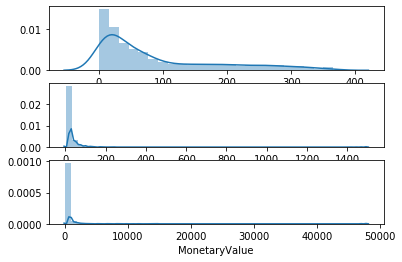

In [26]:
import seaborn as sns

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_rfm['MonetaryValue'])

# Show the plot
plt.show()

### Pre-process RFM data

Since the variables are skewed and are on different scales, you will now un-skew and normalize them.

In [30]:
from sklearn.preprocessing import StandardScaler

# Unskew the data
datamart_log = np.log(datamart_rfm)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized = pd.DataFrame (data=datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

datamart_normalized.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,-2.193847,0.865157,1.464940
12748,-2.687683,3.815272,2.994692
12749,-1.700010,1.189117,1.347598
12820,-1.904971,0.546468,0.500595
12822,0.349287,0.020925,0.037943


### Visualize the normalized variables
Now you will plot the normalized and unskewed variables to see the difference in the distribution as well as the range of the values.

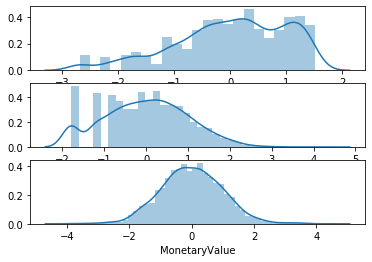

In [32]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_normalized['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue'])

# Show the plot
plt.show()

### Customer Segmentation with K-means

#### Choosing the number of clusters

##### Calculate sum of squared errors
In this exercise, you will calculate the sum of squared errors for different number of clusters ranging from 1 to 10.

In [47]:
# Import KMeans 
from sklearn.cluster import KMeans

In [48]:
sse={}

# Fit KMeans and calculate SSE for each k
for k in range(1, 11):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(datamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

#### Plot sum of squared errors
Now you will plot the sum of squared errors for each value of k and identify if there is an elbow. This will guide you towards the recommended number of clusters to use.

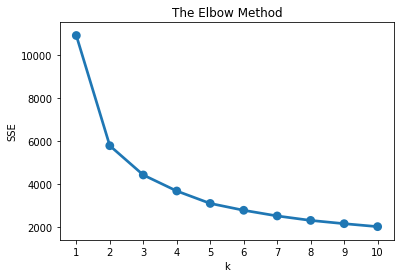

In [49]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

* 3 or 4 is a good choice!!!

#### Running k-means

In [45]:
#initialize KMeans
kmeans = KMeans(n_clusters=4, random_state=1)

#Compute k-means clustering on pre-processed data
kmeans.fit(datamart_normalized)

#Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

#### Approaches to build customer personas
- Summary statistics for each cluster e.g. average RFM values
- Snake plots (from market research
- Relative importance of cluster attributes compared to population

##### Summary statistics of each cluster

In [54]:
# Calculate average RFM values and sizes for each cluster:

datamart_rfm_k4 = datamart_rfm.assign(Cluster = cluster_labels)
datamart_rfm_k4.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12747,2,25,948.70,3
12748,1,888,7046.16,3
12749,4,37,813.45,3
12820,3,17,268.02,2
12822,71,9,146.15,0


In [46]:
datamart_rfm_k4.groupby(['Cluster']).agg({
                        'Recency': 'mean',
                        'Frequency': 'mean',
                        'MonetaryValue': ['mean', 'count'],
                        }).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         117.0      13.0         248.0  1151
1         163.0       3.0          48.0  1026
2          17.0      10.0         145.0   689
3          17.0      56.0        1180.0   777

##### Snake plots to understand and compare segments
- Market research technique to compare different segments
- Visual representation of each segment's attributes
- Need to first normalize data (center & scale)
- Plot each cluster's average normalized values of each attribute

In [53]:
datamart_normalized

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,-2.193847,0.865157,1.464940
12748,-2.687683,3.815272,2.994692
12749,-1.700010,1.189117,1.347598
12820,-1.904971,0.546468,0.500595
12822,0.349287,0.020925,0.037943
...,...,...,...
18280,1.321747,-1.221955,-0.975812
18281,1.016015,-1.221955,-1.125628
18282,-1.206173,-1.221955,-1.152485


In [55]:
datamart_normalized['Cluster'] = datamart_rfm_k4['Cluster']

* Melt the data into a long format so RFM values and metric names are stored in 1 column each

In [70]:
datamart_melt = pd.melt(datamart_normalized.reset_index(),
                        id_vars=['CustomerID', 'Cluster'],
                        value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                        var_name='Metric',
                        value_name='Value')

##### Visualize a snake plot

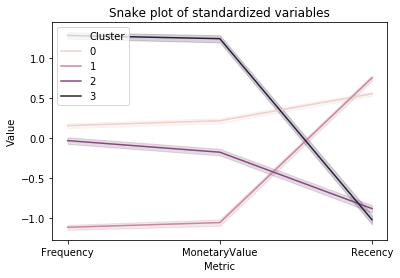

In [71]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Metric", y="Value", hue='Cluster', data=datamart_melt);

#### Relative importance of segment attributes
- Useful technique to identify relative importance of each segment's attribute
- Calculate average values of each cluster
- Calculate average values of population
- Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)

In [62]:
cluster_avg = datamart_rfm_k4.groupby(['Cluster']).mean()

population_avg = datamart_rfm.mean()

relative_imp = cluster_avg / population_avg - 1

##### Analyze and plot relative importance
The further a ratio is from 0, the more important that attribute is for a segment
relative to the total population.

In [64]:
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,0.30,-0.31,-0.33
1,0.82,-0.85,-0.87
2,-0.81,-0.44,-0.61
3,-0.81,1.98,2.18


- Plot a heatmap for easier interpretation:

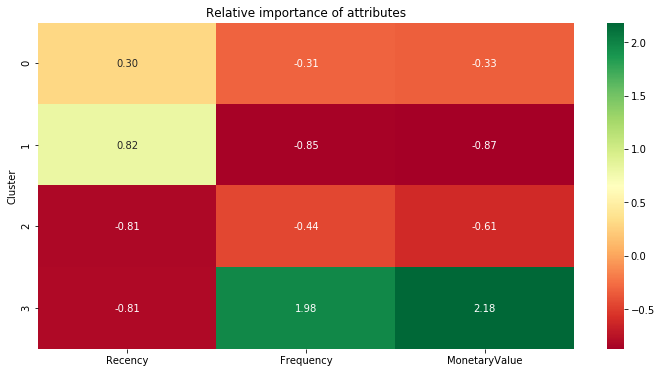

In [69]:
plt.figure(figsize=(12, 6))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

### End-to-end segmentation solution

In [73]:
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

In [84]:
z = urlopen('https://assets.datacamp.com/production/repositories/3202/datasets/eb6a32ed7e5faa4c4b237ab8afb94df55bb4b3a5/chapter_4.zip')
myzip = ZipFile(BytesIO(z.read())).extract('datamart_rfmt.csv')
datamart_rfmt = pd.read_csv(myzip)

In [85]:
datamart_rfmt.set_index('CustomerID', inplace=True)

In [86]:
datamart_rfmt.head()

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12747,3,25,948.70,362
12748,1,888,7046.16,365
12749,4,37,813.45,214
12820,4,17,268.02,327
12822,71,9,146.15,88


In [87]:
datamart_rfmt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3643 entries, 12747 to 18287
Data columns (total 4 columns):
Recency          3643 non-null int64
Frequency        3643 non-null int64
MonetaryValue    3643 non-null float64
Tenure           3643 non-null int64
dtypes: float64(1), int64(3)
memory usage: 142.3 KB


#### Pre-process data
First step in the segmentation process is to pre-process the data. You will apply log transformation, and then normalize the data to prepare it for clustering.

In [88]:
# Import StandardScaler 
from sklearn.preprocessing import StandardScaler

# Apply log transformation
datamart_rfmt_log = np.log(datamart_rfmt)

# Initialize StandardScaler and fit it 
scaler = StandardScaler(); scaler.fit(datamart_rfmt_log)

# Transform and store the scaled data as datamart_rfmt_normalized
datamart_rfmt_normalized = scaler.transform(datamart_rfmt_log)

In [89]:
datamart_rfmt_normalized

array([[-2.00220213,  0.865157  ,  1.4649405 ,  0.91969471],
       [-2.81451782,  3.81527235,  2.99469233,  0.92875045],
       [-1.78948954,  1.18911731,  1.34759823,  0.34290634],
       ...,
       [-1.27697541, -1.22195523, -1.15248482, -3.26323697],
       [-1.78948954,  2.35670574,  0.86642248,  0.84442534],
       [-0.03348042,  0.44304102,  0.79793723,  0.27958601]])

#### Calculate and plot sum of squared errors
Now, you will calculate the sum of squared errors for different number of clusters ranging from 1 to 10.

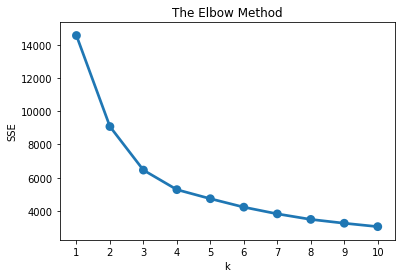

In [92]:
# Fit KMeans and calculate SSE for each k between 1 and 10

sse = {}

for k in range(1, 11):
  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=k, random_state=1).fit(datamart_rfmt_normalized)
    
    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_   

# Add the plot title, x and y axis labels
plt.title('The Elbow Method'); plt.xlabel('k'); plt.ylabel('SSE')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

- The elbow is visible around 3-4 clusters!

### Build 4-cluster solution
Perfect, you can see the the recommended number of clusters is somewhere between 3 and 4. Now, you will build the latter number of clusters in this exercise.

In [95]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=4, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_rfmt_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

-  You have built 4-cluster segmentation and can now use it to create customer personas!

### Analyze the segments
Final step - analyzing your segmentation solution - you will analyze the average Recency, Frequency, MonetaryValue and Tenure values for each of the four segments you have built previously.

In [98]:
# Create a new DataFrame by adding a cluster label column to datamart_rfmt
datamart_rfmt_k4 = datamart_rfmt.assign(Cluster=cluster_labels)

# Group by cluster
grouped = datamart_rfmt_k4.groupby(['Cluster'])

# Calculate average RFMT values and segment sizes for each cluster
grouped.agg({
            'Recency': 'mean',
            'Frequency': 'mean',
            'MonetaryValue': 'mean',
            'Tenure': ['mean', 'count']
          }).round(1)

Recency Frequency MonetaryValue Tenure      
           mean      mean          mean   mean count
Cluster                                             
0         203.6       3.3          58.6  221.9   923
1          13.0      54.3        1151.6  279.9   761
2          88.2      15.2         283.5  247.8  1215
3          32.8       7.2         101.6   44.9   744

Source: Datacamp